This file is used to generate a pandas dataframe for the Y106 filter. It differs from the 'Roman Observations' file by having a section that generates new mjd and datetime values because the DCC sims for Y106 had too many repeated pointings, mjd, and datetime values to be transferred to the new data. This file also relies on the 'simple_model_images_files_data.csv' file. No changes are needed to this file unless the observing strategy has changed.

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt

In [2]:
og_df = pd.read_csv('simple_model_images_files_data.csv')

In [3]:
df = og_df[(og_df['POINTING'] == 110)]

In [65]:
def get_vertices(df, index):
    '''
    Function to convert ra and dec values into vectors compatible with healpy
    Arguments: The dataframe and the index value of the row corresponding to the SCA that will be plotted.
    Returns: An array of vertices in the form of vectors for each corner of the SCA.
    '''
    ra1 = df['RA1'][index]
    ra2 = df['RA2'][index]
    ra3 = df['RA3'][index]
    ra4 = df['RA4'][index]
    dec1 = df['DEC1'][index]
    dec2 = df['DEC2'][index]
    dec3 = df['DEC3'][index]
    dec4 = df['DEC4'][index]
    def ra_dec_to_theta_phi(ra, dec):
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        theta = np.pi / 2 - dec_rad
        phi = ra_rad
        return theta, phi
    theta1, phi1 = ra_dec_to_theta_phi(ra1, dec1)
    theta2, phi2 = ra_dec_to_theta_phi(ra2, dec2)
    theta3, phi3 = ra_dec_to_theta_phi(ra3, dec3)
    theta4, phi4 = ra_dec_to_theta_phi(ra4, dec4)
    vec1 = hp.ang2vec(theta1, phi1)
    vec2 = hp.ang2vec(theta2, phi2)
    vec3 = hp.ang2vec(theta3, phi3)
    vec4 = hp.ang2vec(theta4, phi4)
    vertices = np.array([vec1, vec2, vec3, vec4])
    return vertices

In [6]:
NSIDE = 4096
NPIX  = hp.nside2npix(NSIDE)

In [7]:
def translate_squares(df, shift=0.01, upward_repetitions=1, left_translation=True, downward_repetitions=1):
    """
    Function to create the tiling of the footprint, following the snake pattern outlined in (Wang et al., 2023). It works left to right if visualized using healpy gnomview(). 
    Arguments:
        df: Must be a dataframe that contains only one pointing (only 18 rows). Contains columns RA{i} and DEC{i} for the 4 corner coordinates of every SCA.
        shift: change this value to alter the spacing between rows of pointings. (Increase it and the space between decreases and vice versa.)
        upward_repetitions: One less than the number of desired rows
        left translation: True if another column is desired.
        downward_repetitions: One less than the number of desired rows
    Output: Original dataframe with the rows corresponding to the new pointings appended to the end.
    
    """
    # Step 1: Identify the bounding box
    single_pointing = df.tail(18)
    min_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].min().min()
    max_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].max().max()
    

    # Step 2: Calculate the upward translation distance
    translation_distance_up = max_dec - min_dec - shift

    # Initialize the result dataframe with the original data
    result_df = df.copy()

    # Step 3: Apply the upward translations
    for i in range(upward_repetitions):
        # Translate each corner's Dec coordinates upward
        translated_df = single_pointing.copy()
        translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] += (i + 1) * translation_distance_up
        
        # Append the translated squares to the result dataframe
        result_df = pd.concat([result_df, translated_df], ignore_index=True)

    if left_translation:
        # Step 4: Extract the last set of translated squares
        last_set = result_df.tail(18)
        
        # Step 5: Calculate the left translation distance
        min_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].min().min()
        max_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].max().max()
        translation_distance_left = max_ra - min_ra - shift
        
        # Step 6: Apply the left translation to the last set
        last_set_left_translated = last_set.copy()
        last_set_left_translated[['RA1', 'RA2', 'RA3', 'RA4']] += translation_distance_left

        # Append the left-translated squares to the result dataframe
        result_df = pd.concat([result_df, last_set_left_translated], ignore_index=True)

        # Step 7: Apply the downward translations to the left-translated set
        for i in range(downward_repetitions):
            downward_translated_df = last_set_left_translated.copy()
            downward_translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] -= (i + 1) * translation_distance_up
            result_df = pd.concat([result_df, downward_translated_df], ignore_index=True)

    return result_df

### 8*5 with corners removed = 36 exposures

In [8]:
trans = translate_squares(df, shift=0.01, upward_repetitions=7, left_translation=True, downward_repetitions=7)
trans2 = translate_squares(trans, shift=0.01, upward_repetitions=0, left_translation=True, downward_repetitions=0)
trans3 = translate_squares(trans2, shift=0.01, upward_repetitions=7, left_translation=True, downward_repetitions=7)
trans4 = translate_squares(trans3, shift=0.01, upward_repetitions=0, left_translation=True, downward_repetitions=0)
new_df = translate_squares(trans4, shift=0.01, upward_repetitions=7, left_translation=False, downward_repetitions=0)

In [9]:
obs_rows = new_df.index

In [10]:
ipix_box_list = []
for index in obs_rows:
    vertices = get_vertices(new_df, index)
    ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
    ipix_box_list.append(ipix_box_single)
ipix_box = np.concatenate(ipix_box_list)

In [11]:
rot = [9.7, -44]
m = np.zeros(hp.nside2npix(NSIDE))
counts = np.bincount(ipix_box, minlength=len(m))
m[:len(counts)] = counts

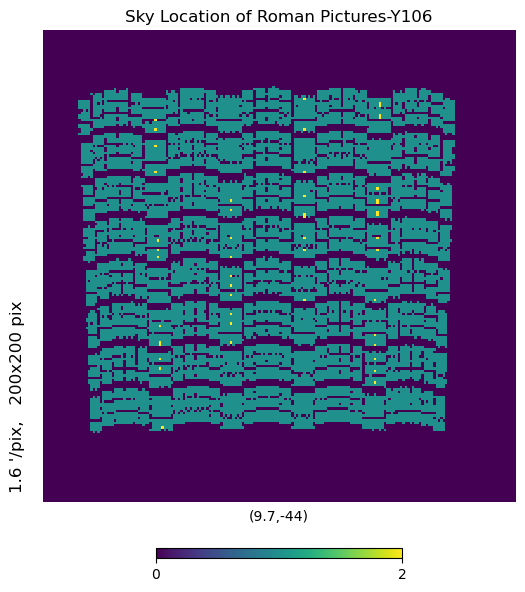

In [12]:
hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-Y106", reso = 1.6, xsize = 200)
plt.show()

In [13]:
#Reusing the pointing values from R062 because the Y106 values have duplicates and the exact value is not important because it's used to remove the corners.
R062 = og_df[(og_df['FILTER'] == 'R062')]

In [14]:
sorted_df = R062.sort_values(by='POINTING')

In [15]:
ra1_array = new_df['RA1'].values
ra2_array = new_df['RA2'].values
ra3_array = new_df['RA3'].values
ra4_array = new_df['RA4'].values
dec1_array = new_df['DEC1'].values
dec2_array = new_df['DEC2'].values
dec3_array = new_df['DEC3'].values
dec4_array = new_df['DEC1'].values

In [16]:
SCA_array = new_df['SCA'].values
pointing_array = sorted_df['POINTING'].values
mjd_array = sorted_df['MJD'].values
dateobs_array = sorted_df['DATE-OBS'].values

In [17]:
data = {
    'POINTING': pointing_array[:720],
    'SCA': SCA_array,
    'MJD': mjd_array[:720],
    'DATE-OBS': dateobs_array[:720],
    'RA1': ra1_array,
    'DEC1':dec1_array,
    'RA2': ra2_array,
    'DEC2': dec2_array,
    'RA3': ra3_array,
    'DEC3': dec3_array,
    'RA4': ra4_array,
    'DEC4': dec4_array
}

In [18]:
nuevo_df = pd.DataFrame(data)

In [19]:
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 0].index
nuevo_df.drop(indices_to_drop, inplace=True)
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 7].index
nuevo_df.drop(indices_to_drop, inplace=True)
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 32].index
nuevo_df.drop(indices_to_drop, inplace=True)
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 39].index
nuevo_df.drop(indices_to_drop, inplace=True)

In [20]:
nuevo_df = nuevo_df.reset_index(drop=True)

In [21]:
obs_rows = nuevo_df.index

In [22]:
ipix_box_list = []
for index in obs_rows:
    vertices = get_vertices(nuevo_df, index)
    ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
    ipix_box_list.append(ipix_box_single)
ipix_box = np.concatenate(ipix_box_list)

In [23]:
rot = [9.7, -44]
m = np.zeros(hp.nside2npix(NSIDE))
counts = np.bincount(ipix_box, minlength=len(m))
m[:len(counts)] = counts

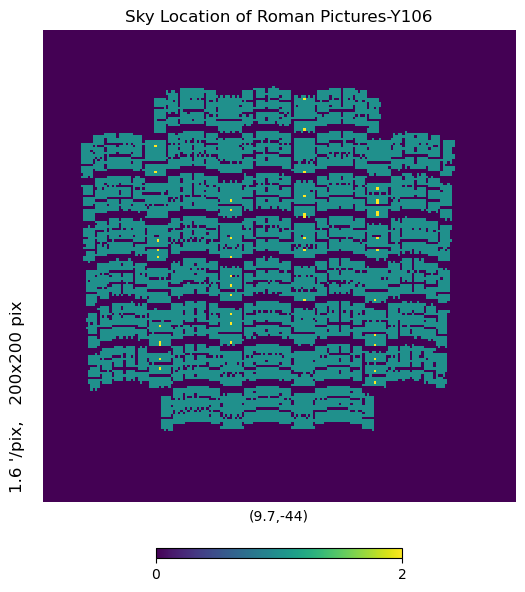

In [24]:
hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-Y106", reso = 1.6, xsize = 200)
plt.show()

In [25]:
def rotate_point(x, y, angle_rad):
    """Rotate a point clockwise by a given angle around the origin (0, 0)."""
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    
    x_new = cos_angle * x + -sin_angle * y
    y_new = sin_angle * x + cos_angle * y
    
    return x_new, y_new

In [66]:
def rotate_squares(df, foot_angle_deg):
    '''
    Function to rotate the footprint clockwise once as viewed in the gnomview projection. 
    Commented out, there is code to also rotate individual pointings if desired. The angle of rotation and a list of lists of indices corresponding to the groups of SCAs in a pointing would need to be added as arguments in the function.
    The previous names for these arguments were point_angle_deg and subset_indices_list.
    Inputs: 
        Dataframe that contains the rows for the footprint. 
        foot_angle_deg is the rotation angle in degrees that you want to rotate the footprint by.
    Output: A dataframe of corner ra and dec coordinates for the rotated footprint. (If angle is 0 then it is the ra and dec coordinates for the original footprint).    
    '''
     
    # Convert angles from degrees to radians
    angle_rad = np.radians(foot_angle_deg)
    #subset_angle_rad = np.radians(point_angle_deg) 

    # Calculate the center of the entire set
    ra_center = df[[f'RA{i}' for i in range(1, 5)]].values.mean()
    dec_center = df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

    # Initialize an empty DataFrame to store rotated squares
    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    # Apply the initial rotation to the entire set
    for index, row in (df.tail(648)).iterrows():
        for i in range(1, 5):
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            # Translate points to origin (center of the entire set)
            ra_translated = ra - ra_center
            dec_translated = dec - dec_center

            # Rotate the points
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)
            
         # Translate points back to the original position
            rotated_data[f'RA{i}'].append(ra_rot + ra_center)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_center)

    # Create a DataFrame for the initially rotated squares
    rotated_df = pd.DataFrame(rotated_data)

    # Apply the additional rotation to each subset
    #for subset_indices in subset_indices_list:
     #   subset_df = rotated_df.iloc[subset_indices]
      #  ra_center_subset = subset_df[[f'RA{i}' for i in range(1, 5)]].values.mean()
       # dec_center_subset = subset_df[[f'DEC{i}' for i in range(1, 5)]].values.mean()
        
        #for index in subset_indices:
         #   row = rotated_df.loc[index]
          #  for i in range(1, 5):
           #     ra, dec = row[f'RA{i}'], row[f'DEC{i}']

                # Translate points to origin (center of the subset)
              #  ra_translated = ra - ra_center_subset
               # dec_translated = dec - dec_center_subset

                # Rotate the points
                #ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, subset_angle_rad)

                # Translate points back to the original position
                #rotated_df.at[index, f'RA{i}'] = ra_rot + ra_center_subset
                #rotated_df.at[index, f'DEC{i}'] = dec_rot + dec_center_subset
    result_df = rotated_df

    return result_df


In [67]:
list1 = list(range(0, 726, 5))
list2 = [1550, 1555, 1560]

In [28]:
foot_angles_list = []

for day in list1:
    angle = (360 / 365) * day
    foot_angles_list.append(angle)

In [30]:
#group_size = 18
#num_rows = len(nuevo_df)
#indices = nuevo_df.index.tolist()

#list_of_lists = []
#for i in range(0, num_rows, group_size):
 #   list_of_lists.append(indices[i:i + group_size])

In [31]:
result_df = pd.DataFrame()

for foot_angle in foot_angles_list:
    # Rotate the original DataFrame by the current angle
    rotated_df = rotate_squares(nuevo_df, foot_angle)
    # Append the rotated DataFrame to the result
    result_df = pd.concat([result_df, rotated_df], ignore_index=True)

In [32]:
result_df

,RA1,RA2,RA3,RA4,DEC1,DEC2,DEC3,DEC4
0,7.981160,7.984084,7.809367,7.806806,-44.901579,-45.018909,-45.017586,-44.901579
1,7.809069,7.806899,7.984775,7.987336,-45.297976,-45.175284,-45.175660,-45.297976
2,8.175276,8.179839,8.006018,8.001821,-44.966651,-45.085057,-45.083193,-44.966651
3,7.208522,7.204540,7.030568,7.034916,-44.964705,-45.083186,-45.085134,-44.964705
4,7.788506,7.790172,7.614850,7.613548,-44.874391,-44.991338,-44.991228,-44.874391
...,...,...,...,...,...,...,...,...
94603,11.886067,11.899151,12.074758,12.061979,-42.920826,-42.801363,-42.815676,-42.936005
94604,12.085811,12.073106,11.898920,11.912090,-42.686838,-42.803515,-42.789682,-42.671849
94605,12.468447,12.476318,12.651718,12.644296,-42.970237,-42.850324,-42.866302,-42.985410
94606,12.082352,12.093541,12.269656,12.258808,-42.910830,-42.791512,-42.806286,-42.926056


In [33]:
ra_centers = []
dec_centers = []
# Loop through the DataFrame in chunks of 'subset_size'
for i in range(0, len(result_df), 18):
    subset = result_df.iloc[i:i + 18]
        
    # Calculate the mean RA and Dec for the subset
    ra_center = subset[[f'RA{j}' for j in range(1, 5)]].values.mean()
    dec_center = subset[[f'DEC{j}' for j in range(1, 5)]].values.mean()
        
    ra_centers.append(ra_center)
    dec_centers.append(dec_center)

In [34]:
ras_array = [item for item in ra_centers for _ in range(18)]
decs_array = [item for item in dec_centers for _ in range(18)]

In [35]:
ra_center = nuevo_df[[f'RA{i}' for i in range(1, 5)]].values.mean()
dec_center = nuevo_df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

In [36]:
ra_center_array = [ra_center]*94608

In [37]:
dec_center_array = [dec_center]*94608

In [38]:
foot_angles_array = [item for item in foot_angles_list for _ in range(648)]

In [39]:
#This generates mjd values starting at the original start on DCC and following a similar pattern as the times on DCC do. I got the pattern by printing the mjd values for 1 day and asking chat gpt to analyze the pattern.
mjd = []
current_start = 62000.39804
for _ in range(146):
    group = [current_start + i * 0.00431 for i in range(36)]
    mjd.extend(group)
    current_start += 5

In [40]:
mjd_array = [item for item in mjd for _ in range(18)]

In [41]:
#To get the datetime values, define a conversion function from mjd to datetime.
from datetime import datetime

In [42]:
# Define the conversion function
def julian_date_to_gregorian(mjd):
    julian_date = mjd + 2400000.5 #Go from MJD to JD
    JDN = int(julian_date + 0.5)
    F = (julian_date + 0.5) - JDN
    
    if JDN >= 2299161:
        A = int((JDN - 1867216.25) / 36524.25)
        B = JDN + 1 + A - int(A / 4)
    else:
        B = JDN
    
    C = B + 1524
    D = int((C - 122.1) / 365.25)
    E = int(365.25 * D)
    G = int((C - E) / 30.6001)
    
    day = C - E + F - int(30.6001 * G)
    
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13
    
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
    
    day_fraction = day % 1
    day = int(day)
    
    hours = int(day_fraction * 24)
    minutes = int((day_fraction * 24 - hours) * 60)
    seconds = int(((day_fraction * 24 - hours) * 60 - minutes) * 60)
    
    return datetime(year, month, day, hours, minutes, seconds)
    

In [43]:
date_obs_array = [julian_date_to_gregorian(mjd) for mjd in mjd_array]

In [44]:
# Initialize the list to store the numbers
pointings = []

# Start value for the first block
start_value = 72

# Create the list using a loop
for block in range(146):
    # Create the current block of consecutive numbers
    block_values = list(range(start_value, start_value + 36))
    # Append the block to the result list
    pointings.extend(block_values)
    # Update the start value for the next block
    start_value = block_values[-1] + 1 + 216

In [45]:
pointing_array = [item for item in pointings for _ in range(18)]

In [48]:
Y106 = og_df[(og_df['FILTER'] == 'Y106')]

In [49]:
sorted_df = Y106.sort_values(by='POINTING')

In [50]:
filter_array = sorted_df['FILTER'].values

In [51]:
exp_time = sorted_df['EXPTIME'].values

In [52]:
SCAs = df['SCA'].values

In [53]:
SCA_array = np.tile(SCAs, 5256)

In [54]:
result_df.insert(0, 'POINTING', pointing_array)

In [55]:
result_df.insert(1, 'SCA', SCA_array)

In [56]:
result_df['SCA'] = result_df['SCA'].astype(int)

In [57]:
result_df.insert(2, 'FILTER', filter_array[:94608])

In [58]:
result_df.insert(3, 'MJD', mjd_array)

In [59]:
result_df.insert(4, 'EXPTIME', exp_time[:94608])

In [60]:
result_df.insert(5, 'DATE-OBS', date_obs_array)

In [61]:
result_df.insert(6, 'EXP CENTER- RA', ras_array)
result_df.insert(7, 'EXP CENTER- DEC', decs_array)

In [62]:
result_df.insert(8, 'MAJOR ROT AXS- RA', ra_center_array)
result_df.insert(9, 'MAJOR ROT AXS- DEC', dec_center_array)
result_df.insert(10, 'MAJOR ROT ANGLE', foot_angles_array)

In [63]:
result_df

,POINTING,SCA,FILTER,MJD,EXPTIME,DATE-OBS,EXP CENTER- RA,EXP CENTER- DEC,MAJOR ROT AXS- RA,MAJOR ROT AXS- DEC,MAJOR ROT ANGLE,RA1,RA2,RA3,RA4,DEC1,DEC2,DEC3,DEC4
0,72,6,Y106,62000.39804,302.275,2028-08-17 09:33:10,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.981160,7.984084,7.809367,7.806806,-44.901579,-45.018909,-45.017586,-44.901579
1,72,4,Y106,62000.39804,302.275,2028-08-17 09:33:10,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.809069,7.806899,7.984775,7.987336,-45.297976,-45.175284,-45.175660,-45.297976
2,72,9,Y106,62000.39804,302.275,2028-08-17 09:33:10,7.60534,-45.108231,9.889758,-43.909362,0.000000,8.175276,8.179839,8.006018,8.001821,-44.966651,-45.085057,-45.083193,-44.966651
3,72,18,Y106,62000.39804,302.275,2028-08-17 09:33:10,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.208522,7.204540,7.030568,7.034916,-44.964705,-45.083186,-45.085134,-44.964705
4,72,3,Y106,62000.39804,302.275,2028-08-17 09:33:10,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.788506,7.790172,7.614850,7.613548,-44.874391,-44.991338,-44.991228,-44.874391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94603,36647,14,Y106,62725.54889,302.275,2030-08-12 13:10:24,12.26878,-42.911312,9.889758,-43.909362,715.068493,11.886067,11.899151,12.074758,12.061979,-42.920826,-42.801363,-42.815676,-42.936005
94604,36647,15,Y106,62725.54889,302.275,2030-08-12 13:10:24,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.085811,12.073106,11.898920,11.912090,-42.686838,-42.803515,-42.789682,-42.671849
94605,36647,5,Y106,62725.54889,302.275,2030-08-12 13:10:24,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.468447,12.476318,12.651718,12.644296,-42.970237,-42.850324,-42.866302,-42.985410
94606,36647,11,Y106,62725.54889,302.275,2030-08-12 13:10:24,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.082352,12.093541,12.269656,12.258808,-42.910830,-42.791512,-42.806286,-42.926056


In [64]:
result_df.to_csv('Y106_files_data.csv', index=False)